# qPCR analysis

In [8]:
a = [256.8,119.0,263.8,156.9,210.1,231.7,222.3,274.2,225.2,268.0,093.7,180.2,118.7,215.5,205.6,080.0]
np.divide(np.multiply(a,27),(30+27))

array([121.64210526,  56.36842105, 124.95789474,  74.32105263,
        99.52105263, 109.75263158, 105.3       , 129.88421053,
       106.67368421, 126.94736842,  44.38421053,  85.35789474,
        56.22631579, 102.07894737,  97.38947368,  37.89473684])

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import pygal
import math
import IPython
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import importlib
import svgutils
from svgutils.compose import *
import os.path
from cmcrameri import cm #colormaps

## &Delta;&Delta;C<sub>t</sub> nethod

In [3]:
batlow = cm.vik(range(255))
batlow = batlow[0:255:int(np.floor(255/8)),:]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=batlow) 

# Colors
zfC = {
    'rho' : '#7d7d7d',
    'sws1' : '#B73AB9',
    'sws2' : '#4364F6',
    'mws1' : '#59CB3B',
    'mws2' : '#59CB3B',
    'mws3' : '#59CB3B',
    'mws4' : '#59CB3B',
    'lws1' : '#CE2A22',
    'lws2' : '#CE2A22',
    'actb2': '#926645',
    'tbx2a': '#c92675',
    'tbx2b': '#7526c9',
}


def formatFigureMain(figH, axH, plotH):
    font_path = '/System/Library/Fonts/Avenir.ttc'
    fontTicks = font_manager.FontProperties(fname=font_path, size=18)
    fontLabels = font_manager.FontProperties(fname=font_path, size=22)
    fontTitle = font_manager.FontProperties(fname=font_path, size=28)
    axH.set_xscale('linear')
    axH.spines['top'].set_visible(False)
    axH.spines['right'].set_visible(False)
    
    for label in (axH.get_xticklabels() + axH.get_yticklabels()):
        label.set_fontproperties(fontTicks)
    return fontLabels

def formatFigureCt(figH, axH, plotH):
    fontLabels = formatFigureMain(figH, axH, plotH)
    axH.set_xlabel('Sample', fontproperties=fontLabels)
    axH.set_ylabel('Ct', fontproperties=fontLabels)

def formatFigureFD(figH, axH, plotH):
    fontLabels = formatFigureMain(figH, axH, plotH)
    axH.set_xlabel('Sample', fontproperties=fontLabels)
    axH.set_ylabel('Fold. Diff', fontproperties=fontLabels)
        
def sumstd (a,b):
    sd = np.sqrt(np.square(a)+np.square(b))
    return sd

def getFD(fName,sampleList,wtList,refGene):
    df = pd.read_csv(fName)
    
    geneList = np.unique(df['Target'])
    dCt={}
    dCt['samples'] = sampleList
    for gene in geneList:
        dCt[gene] = [np.mean(df[(df['Sample']==s) & (df['Target']==gene)].Cq)-np.mean(df[(df['Sample']==s) & (df['Target']==refGene)].Cq) for s in sampleList]
        dCt[(gene+'SD')] = [sumstd(np.std(df[(df['Sample']==s) & (df['Target']==gene)].Cq),np.std(df[(df['Sample']==s) & (df['Target']==refGene)].Cq)) for s in sampleList]
    dCt = pd.DataFrame(dCt)

    ddCt = {}
    ddCt['samples'] = sampleList
    for gene in geneList:
        ddCt[gene] = [dCt[(dCt['samples']==s)][gene].item() - np.mean(dCt[dCt['samples'].str.contains("|".join(wtList))][gene]) for s in sampleList]
        ddCt[(gene+'SD')] = [sumstd(dCt[(dCt['samples']==s)][(gene+'SD')].item(),np.std(dCt[dCt['samples'].str.contains("|".join(wtList))][(gene+'SD')]/np.sqrt(np.size(wtList)))) for s in sampleList]
    ddCt = pd.DataFrame(ddCt)

    fd = {} #fold differences
    fd['samples'] = sampleList
    for gene in geneList:
        fd[gene] = [np.power(2,-ddCt[(ddCt['samples']==s)][gene].item()) for s in sampleList]
        fd[(gene + 'Lo')] = [np.power(2,-(ddCt[(ddCt['samples']==s)][gene].item()-ddCt[(ddCt['samples']==s)][(gene + 'SD')].item())) for s in sampleList]
        fd[(gene + 'Hi')] = [np.power(2,-(ddCt[(ddCt['samples']==s)][gene].item()+ddCt[(ddCt['samples']==s)][(gene + 'SD')].item())) for s in sampleList]
    return pd.DataFrame(fd)

print('Loaded!\n')

Loaded!



In [4]:

fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210322_CRtbx2aF0_Opsins.csv"
# fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210326_CRtbx2F0s_opsins.csv"
# fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210329_CRtbx2F0s_opsinsAgain.csv"
fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210402_CRtbx2F0s_m2l2s2.csv"
# fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210402_CRtbx2F0s_tbx2s2.csv"

df = pd.read_csv(fName)
df[df['Target']=='actb2']

,Well,Fluor,Target,Content,Sample,Cq,SQ
0,A01,SYBR,actb2,Unkn,wtL01,19.392423,NaN
1,A02,SYBR,actb2,Unkn,wtL01,19.355644,NaN
2,A03,SYBR,actb2,Unkn,wtL01,19.069122,NaN
9,A10,SYBR,actb2,Unkn,tbx2bL01,24.048199,NaN
10,A11,SYBR,actb2,Unkn,tbx2bL01,24.323270,NaN
11,A12,SYBR,actb2,Unkn,tbx2bL01,24.476874,NaN
12,B01,SYBR,actb2,Unkn,wtL02,19.615136,NaN
13,B02,SYBR,actb2,Unkn,wtL02,19.901213,NaN
14,B03,SYBR,actb2,Unkn,wtL02,18.996386,NaN
24,C01,SYBR,actb2,Unkn,wtL05,19.679539,NaN


In [5]:
np.unique(df['Sample'])

array(['tbx2aL01', 'tbx2aL02', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01',
       'tbx2bL02', 'wtL01', 'wtL02', 'wtL05', 'wtL06'], dtype=object)

In [6]:
# define wt samples and reference ("house-keeping") gene
hkg = 'actb2'

samples=['wtL03', 'wtL05', 'wtL06','tbx2aL03', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01', 'tbx2bL02'] #re-rorganization
wtsamples = ['wtL03', 'wtL05', 'wtL06']
fd = getFD("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210329_CRtbx2F0s_opsinsAgain.csv",samples,wtsamples,hkg)
fd

samples=['wtL03', 'wtL05', 'tbx2aL03', 'tbx2aL04', 'tbx2bL01'] #re-rorganization
wtsamples = ['wtL03', 'wtL05']
fd2 = getFD("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210326_CRtbx2F0s_opsins.csv",samples,wtsamples,hkg)
fd2

samples=['wtL01', 'wtL02', 'ntng2bL01', 'tbx2aL01', 'tbx2aL02'] #re-rorganization
wtsamples = ['wtL01', 'wtL02']
# hkg = 'sws2'
fd3 = getFD("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210322_CRtbx2aF0_Opsins.csv",samples,wtsamples,hkg)
fd3

samples=['tbx2aL01', 'tbx2aL02', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01','tbx2bL02', 'wtL01', 'wtL02', 'wtL05', 'wtL06'] #re-rorganization
wtsamples = [ 'wtL01', 'wtL02', 'wtL05', 'wtL06']
# hkg = 'sws2'
fd4 = getFD("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210331_CRtbx2F0_s2m2.csv",samples,wtsamples,hkg)
fd4

samples=['wtL01', 'wtL02', 'wtL05', 'wtL06','tbx2aL01', 'tbx2aL02', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01','tbx2bL02'] #re-rorganization
wtsamples = [ 'wtL01', 'wtL02', 'wtL05', 'wtL06']
# hkg = 'sws2'
fd5 = getFD("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210402_CRtbx2F0s_m2l2s2.csv",samples,wtsamples,hkg)
fd5

samples=['wtL01', 'wtL02', 'wtL05', 'wtL06','tbx2aL01', 'tbx2aL02', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01','tbx2bL02'] #re-rorganization
wtsamples = [ 'wtL01', 'wtL02', 'wtL05', 'wtL06']
# hkg = 'sws2'
fd6 = getFD("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210402_CRtbx2F0s_tbx2s2.csv",samples,wtsamples,hkg)
fd6


,samples,actb2,actb2Lo,actb2Hi,sws2,sws2Lo,sws2Hi,tbx2a,tbx2aLo,tbx2aHi,tbx2b,tbx2bLo,tbx2bHi
0,wtL01,1.0,1.552252,0.644225,NaN,NaN,NaN,0.367137,0.961615,0.140170,0.389054,0.595021,0.254383
1,wtL02,1.0,1.158951,0.862849,0.206643,0.580113,0.073609,1.114487,1.373825,0.904105,0.987714,1.500123,0.650333
2,wtL05,1.0,1.194090,0.837458,2.313598,2.851731,1.877013,1.502413,1.916431,1.177838,1.943788,3.987357,0.947573
3,wtL06,1.0,2.025393,0.493731,2.091661,3.700304,1.182347,1.626698,2.730542,0.969092,1.338782,4.865948,0.368343
4,tbx2aL01,1.0,1.132029,0.883369,0.314823,0.380287,0.260629,0.090322,0.206335,0.039538,0.252019,0.337152,0.188383
5,tbx2aL02,1.0,1.158561,0.863140,0.461045,0.561465,0.378585,0.443394,0.528728,0.371833,0.575623,0.745593,0.444401
6,tbx2aL04,1.0,1.271988,0.786171,3.471524,4.705074,2.561380,1.839573,2.426019,1.394890,3.544006,4.544231,2.763939
7,tbx2aL05,1.0,1.138898,0.878042,1.605347,1.977214,1.303419,0.818729,1.098956,0.609957,1.415920,1.844999,1.086629
8,tbx2bL01,1.0,2.138099,0.467705,0.485644,0.852582,0.276630,0.077765,0.359279,0.016832,0.561951,1.191129,0.265118
9,tbx2bL02,1.0,1.272469,0.785873,0.845023,1.072957,0.665510,1.571227,2.005371,1.231071,2.307464,3.022157,1.761784


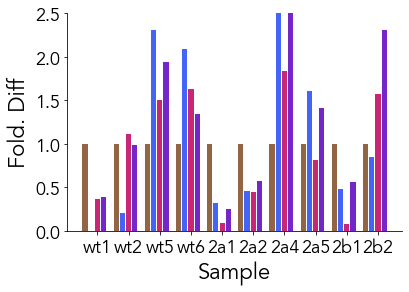

In [7]:
samples = np.unique(df['Sample'])
samples=[ 'wtL01', 'wtL02', 'wtL05', 'wtL06','tbx2aL01', 'tbx2aL02', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01','tbx2bL02'] #re-rorganization

geneList = ['actb2','sws2','tbx2a','tbx2b']

plotname = ''
fH, axH = plt.subplots()

relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+1;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd6[(fd6['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);
   

formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(['wt1','wt2','wt5','wt6','2a1','2a2','2a4','2a5','2b1','2b2']);
axH.set_ylim([0,2.5]);

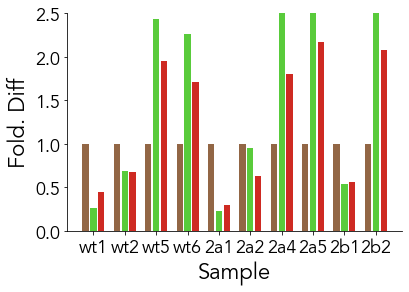

In [8]:
samples = np.unique(df['Sample'])
samples=[ 'wtL01', 'wtL02', 'wtL05', 'wtL06','tbx2aL01', 'tbx2aL02', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01','tbx2bL02'] #re-rorganization

geneList = ['actb2','mws2','lws2']

plotname = ''
fH, axH = plt.subplots()

relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+1;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd5[(fd5['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);
   

formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(['wt1','wt2','wt5','wt6','2a1','2a2','2a4','2a5','2b1','2b2']);
axH.set_ylim([0,2.5]);

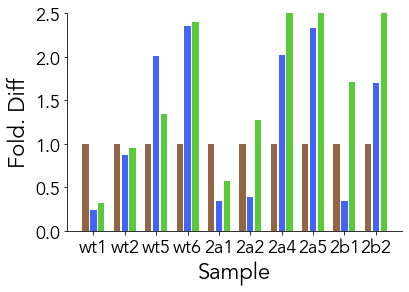

In [9]:
samples = np.unique(df['Sample'])
samples=[ 'wtL01', 'wtL02', 'wtL05', 'wtL06','tbx2aL01', 'tbx2aL02', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01','tbx2bL02'] #re-rorganization

geneList = ['actb2','sws2','mws2']

plotname = ''
fH, axH = plt.subplots()

relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+1;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd4[(fd4['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);
   

formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(['wt1','wt2','wt5','wt6','2a1','2a2','2a4','2a5','2b1','2b2']);
axH.set_ylim([0,2.5]);

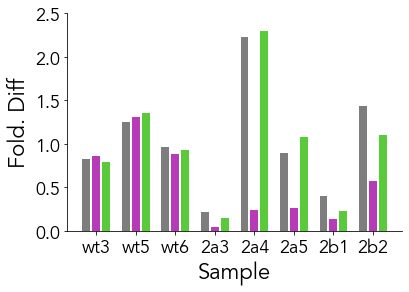

In [10]:
samples = np.unique(df['Sample'])
samples=['wtL03', 'wtL05', 'wtL06','tbx2aL03', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01', 'tbx2bL02'] #re-rorganization

geneList = ['rho','sws1','mws1']

plotname = ''
fH, axH = plt.subplots()

relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+1;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd[(fd['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);
   

formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(['wt3','wt5','wt6','2a3','2a4','2a5','2b1','2b2']);
axH.set_ylim([0,2.5]);

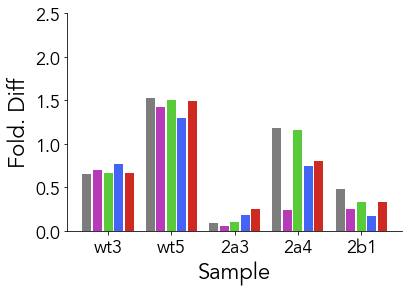

In [11]:
samples=['wtL03', 'wtL05', 'tbx2aL03', 'tbx2aL04', 'tbx2bL01'] #re-rorganization
geneList = ['rho','sws1','mws1','sws2','lws2']

plotname = ''
fH, axH = plt.subplots()
relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+2;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd2[(fd2['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);

   

formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(['wt3','wt5','2a3','2a4','2b1']);
axH.set_ylim([0,2.5]);

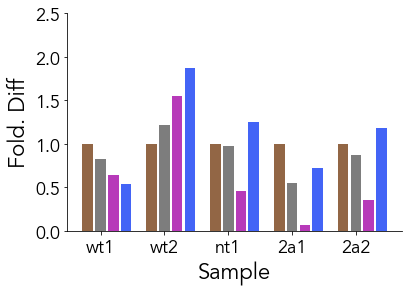

In [12]:
samples=['wtL01', 'wtL02', 'ntng2bL01', 'tbx2aL01', 'tbx2aL02'] #re-rorganization
geneList = ['actb2','rho','sws1','sws2']

plotname = ''
fH, axH = plt.subplots()
relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+2;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd3[(fd3['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);

   

formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(['wt1','wt2','nt1','2a1','2a2']);
axH.set_ylim([0,2.5]);

### Exploring code

In [13]:
# samples = np.unique(df['Sample'])
# samples = ['tbx2aL03', 'tbx2aL04', 'tbx2bL01', 'wtL03', 'wtL05']
# wtL03 = np.mean(df[(df['Sample']=='wtL03') & (df['Target']=='actb2')].Cq)
# wtL04 = np.mean(df[(df['Sample']=='wtL04') & (df['Target']=='actb2')].Cq)
# wtL05 = np.mean(df[(df['Sample']=='wtL05') & (df['Target']=='actb2')].Cq)
# tbx2aL03 = np.mean(df[(df['Sample']=='tbx2aL03') & (df['Target']=='actb2')].Cq)
# tbx2aL04 = np.mean(df[(df['Sample']=='tbx2aL04') & (df['Target']=='actb2')].Cq)
# tbx2bL01 = np.mean(df[(df['Sample']=='tbx2bL01') & (df['Target']=='actb2')].Cq)

fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210322_CRtbx2aF0_Opsins.csv"
# fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210326_CRtbx2F0s_opsins.csv"
# fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210329_CRtbx2F0s_opsinsAgain.csv"
fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210402_CRtbx2F0s_m2l2s2.csv"
fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210402_CRtbx2F0s_tbx2s2.csv"

df = pd.read_csv(fName)
df[df['Target']=='actb2']


samples

df[(df['Sample']==s) & (df['Target']=='actb2')].Cq

61    22.267618
62    22.105121
Name: Cq, dtype: float64

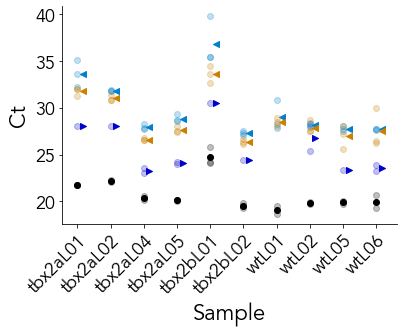

In [14]:
# plots of average Ct values per sample
samples = np.unique(df['Sample'])
# samples=['wtL03', 'wtL05', 'wtL06','tbx2aL03', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01', 'tbx2bL02'] #re-rorganization
samples=['tbx2aL01', 'tbx2aL02', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01','tbx2bL02', 'wtL01', 'wtL02', 'wtL05', 'wtL06'] #re-rorganization


plotname = ''
fH, ax = plt.subplots()
i=0;
for s in samples:
    i = i+1;
    pH = plt.scatter([0+i], np.mean(df[(df['Sample']==s) & (df['Target']=='actb2')].Cq),marker = 'o', color=(0,0,0,1));
    for v in df[(df['Sample']==s) & (df['Target']=='actb2')].Cq:
        pH = plt.scatter([0+i], v,marker = 'o', color=(0,0,0,.25));
    
# i=0;
# for s in samples:
#     i = i+1;
#     pH = plt.scatter([0+i-1/6], np.mean(df[(df['Sample']==s) & (df['Target']=='rho')].Cq), marker = 'v', color=(.5,.5,.5,1));

# i=0;
# for s in samples:
#     i = i+1;
#     pH = plt.scatter([0+i-2/6], np.mean(df[(df['Sample']==s) & (df['Target']=='sws1')].Cq), marker = 'P', color=(.8,.5,.8,1));
    
i=0;
for s in samples:
    i = i+1;
    pH = plt.scatter([0+i+1/6], np.mean(df[(df['Sample']==s) & (df['Target']=='sws2')].Cq), marker = '>', color=(0,0,.8,1));
    for v in df[(df['Sample']==s) & (df['Target']=='sws2')].Cq:
        pH = plt.scatter([0+i], v,marker = 'o', color=(0,0,.8,.25));

# i=0;
# for s in samples:
#     i = i+1;
#     pH = plt.scatter([0+i+2/6], np.mean(df[(df['Sample']==s) & (df['Target']=='mws2')].Cq), marker = '<', color=(0,.8,0,1));
#     for v in df[(df['Sample']==s) & (df['Target']=='mws2')].Cq:
#         pH = plt.scatter([0+i], v,marker = 'o', color=(0,.8,0,.25));

# i=0;
# for s in samples:
#     i = i+1;
#     pH = plt.scatter([0+i+1/6], np.mean(df[(df['Sample']==s) & (df['Target']=='lws2')].Cq), marker = '<', color=(.8,0,0,1));
#     for v in df[(df['Sample']==s) & (df['Target']=='lws2')].Cq:
#         pH = plt.scatter([0+i], v,marker = 'o', color=(.8,0,0,.25));


i=0;
for s in samples:
    i = i+1;
    pH = plt.scatter([0+i+1/6], np.mean(df[(df['Sample']==s) & (df['Target']=='tbx2a')].Cq), marker = '<', color=(0,0.5,0.8,1));
    for v in df[(df['Sample']==s) & (df['Target']=='tbx2a')].Cq:
        pH = plt.scatter([0+i], v,marker = 'o', color=(0,0.5,0.8,.25));
    
i=0;
for s in samples:
    i = i+1;
    pH = plt.scatter([0+i+1/6], np.mean(df[(df['Sample']==s) & (df['Target']=='tbx2b')].Cq), marker = '<', color=(.8,0.5,0,1));
    for v in df[(df['Sample']==s) & (df['Target']=='tbx2b')].Cq:
        pH = plt.scatter([0+i], v,marker = 'o', color=(.8,0.5,0,.25));


formatFigureCt(fH, ax, pH)
# ax.set_xticks([1,2,3,4,5,6]);
# ax.set_xticklabels(['wt3','wt4','wt5','2a3','2a4','2b1']);

ax.set_xticks(range(1,np.size(samples)+1));
ax.set_xticklabels(samples, rotation=45, ha='right', rotation_mode="anchor");

# ax.legend((pH1, pH2, pH3,pH4,pH5,pH6),('wt3','wt4','wt5','2a3','2a4','2b1'),loc='best',ncol=2)

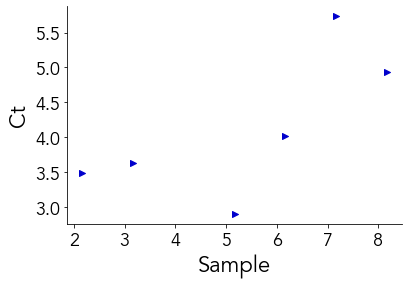

In [15]:
# plots of deltaCt values per sample (it would be better to subtract each then average to not compund error bars, right?)
samples = np.unique(df['Sample'])
samples=['wtL03', 'wtL05', 'wtL06','tbx2aL03', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01', 'tbx2bL02'] #re-rorganization
hkg = 'actb2'
# hkg = 'rho'

plotname = ''
fH, axH = plt.subplots()
    
i=0;
for s in samples:
    i = i+1;
    pH = plt.scatter([0+i-1/6], np.mean(df[(df['Sample']==s) & (df['Target']=='rho')].Cq)-np.mean(df[(df['Sample']==s) & (df['Target']==hkg)].Cq), marker = 'v', color=(.5,.5,.5,1));

i=0;
for s in samples:
    i = i+1;
    pH = plt.scatter([0+i-1/6], np.mean(df[(df['Sample']==s) & (df['Target']=='sws1')].Cq)-np.mean(df[(df['Sample']==s) & (df['Target']==hkg)].Cq), marker = 'P', color=(.8,.5,.8,1));
    
i=0;
for s in samples:
    i = i+1;
    pH = plt.scatter([0+i+1/6], np.mean(df[(df['Sample']==s) & (df['Target']=='sws2')].Cq)-np.mean(df[(df['Sample']==s) & (df['Target']==hkg)].Cq), marker = '>', color=(0,0,.8,1));

i=0;
for s in samples:
    i = i+1;
    pH = plt.scatter([0+i+1/6], np.mean(df[(df['Sample']==s) & (df['Target']=='mws1')].Cq)-np.mean(df[(df['Sample']==s) & (df['Target']==hkg)].Cq), marker = '<', color=(0,.8,0,1));

i=0;
for s in samples:
    i = i+1;
    pH = plt.scatter([0+i+1/6], np.mean(df[(df['Sample']==s) & (df['Target']=='lws2')].Cq)-np.mean(df[(df['Sample']==s) & (df['Target']==hkg)].Cq), marker = '<', color=(.8,0,0,1));

formatFigureCt(fH, axH, pH)
# ax.set_xticks([1,2,3,4,5,6]);
# ax.set_xticklabels(['wt3','wt4','wt5','2a3','2a4','2b1']);

ax.set_xticks(range(1,np.size(samples)+1));
ax.set_xticklabels(samples, rotation=45, ha='right', rotation_mode="anchor");



# ax.legend((pH1, pH2, pH3,pH4,pH5,pH6),('wt3','wt4','wt5','2a3','2a4','2b1'),loc='best',ncol=2)

In [16]:
wtSamples = ['wtL03', 'wtL05', 'wtL06']
expSamples = ['tbx2aL03', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01', 'tbx2bL02']

samples=['wtL03', 'wtL05', 'wtL06','tbx2aL03', 'tbx2aL04', 'tbx2aL05', 'tbx2bL01', 'tbx2bL02'] #re-rorganization

geneList = ['actb2','rho','sws1','mws1']
hkg = 'actb2'
dCt = {}
dCt['samples'] = samples

# dCt['rho'] = [np.mean(df[(df['Sample']==s) & (df['Target']=='rho')].Cq)-np.mean(df[(df['Sample']==s) & (df['Target']==hkg)].Cq) for s in samples]
# dCt['rhoSD'] = [sumstd(np.std(df[(df['Sample']==s) & (df['Target']=='rho')].Cq),np.std(df[(df['Sample']==s) & (df['Target']==hkg)].Cq)) for s in samples]

for gene in geneList:
    dCt[gene] = [np.mean(df[(df['Sample']==s) & (df['Target']==gene)].Cq)-np.mean(df[(df['Sample']==s) & (df['Target']==hkg)].Cq) for s in samples]
    dCt[(gene+'SD')] = [sumstd(np.std(df[(df['Sample']==s) & (df['Target']==gene)].Cq),np.std(df[(df['Sample']==s) & (df['Target']==hkg)].Cq)) for s in samples]
dCt = pd.DataFrame(dCt)

ddCt = {}
ddCt['samples'] = samples
for gene in geneList:
    ddCt[gene] = [dCt[(dCt['samples']==s)][gene].item() - np.mean(dCt[dCt['samples'].str.contains("|".join(wtSamples))][gene]) for s in samples]
    ddCt[(gene+'SD')] = [sumstd(dCt[(dCt['samples']==s)][(gene+'SD')].item(),np.std(dCt[dCt['samples'].str.contains("|".join(wtSamples))][(gene+'SD')]/np.sqrt(np.size(wtSamples)))) for s in samples]
ddCt = pd.DataFrame(ddCt)

fd = {} #fold differences
fd['samples'] = samples
for gene in geneList:
    fd[gene] = [np.power(2,-ddCt[(ddCt['samples']==s)][gene].item()) for s in samples]
    fd[(gene + 'Lo')] = [np.power(2,-(ddCt[(ddCt['samples']==s)][gene].item()-ddCt[(ddCt['samples']==s)][(gene + 'SD')].item())) for s in samples]
    fd[(gene + 'Hi')] = [np.power(2,-(ddCt[(ddCt['samples']==s)][gene].item()+ddCt[(ddCt['samples']==s)][(gene + 'SD')].item())) for s in samples]
fd = pd.DataFrame(fd)
    
fd

,samples,actb2,actb2Lo,actb2Hi,rho,rhoLo,rhoHi,sws1,sws1Lo,sws1Hi,mws1,mws1Lo,mws1Hi
0,wtL03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,wtL05,1.0,1.230458,0.812706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,wtL06,1.0,2.041929,0.489733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tbx2aL03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tbx2aL04,1.0,1.301455,0.768371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,tbx2aL05,1.0,1.183766,0.844762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,tbx2bL01,1.0,2.154320,0.464184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,tbx2bL02,1.0,1.301905,0.768105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
geneList

['actb2', 'rho', 'sws1', 'mws1']

## Std curve to figure out dilutions

In [19]:
batlow = cm.vik(range(255))
batlow = batlow[0:255:int(np.floor(255/8)),:]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=batlow) 


def formatFigure(figH, axH, plotH):
    font_path = '/System/Library/Fonts/Avenir.ttc'
    fontTicks = font_manager.FontProperties(fname=font_path, size=18)
    fontLabels = font_manager.FontProperties(fname=font_path, size=22)
    fontTitle = font_manager.FontProperties(fname=font_path, size=28)
    axH.set_xscale('linear')
    axH.set_ylabel('Ct', fontproperties=fontLabels)
    axH.set_ylabel('Dilution', fontproperties=fontLabels)
    axH.spines['top'].set_visible(False)
    axH.spines['right'].set_visible(False)
    
    

    for label in (axH.get_xticklabels() + axH.get_yticklabels()):
        label.set_fontproperties(fontTicks)

In [20]:
df = pd.read_csv("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210324_CRtbx2F0_stdCurve_actb2_six7.csv")
df[df['Target']=='actb2']

KeyError: 'Target'

In [21]:
dilutions = np.log10([1/10,1/10,1/30,1/30,1/100,1/100])
dilutions

array([-1.        , -1.        , -1.47712125, -1.47712125, -2.        ,
       -2.        ])

In [22]:
wtL03 = df[(df['Sample']=='wtL03') & (df['Target']=='actb2')].Cq
wtL04 = df[(df['Sample']=='wtL04') & (df['Target']=='actb2')].Cq
wtL05 = df[(df['Sample']=='wtL05') & (df['Target']=='actb2')].Cq
tbx2aL03 = df[(df['Sample']=='tbx2aL03') & (df['Target']=='actb2')].Cq
tbx2aL04 = df[(df['Sample']=='tbx2aL04') & (df['Target']=='actb2')].Cq
tbx2aL05 = df[(df['Sample']=='tbx2aL05') & (df['Target']=='actb2')].Cq
tbx2bL01 = df[(df['Sample']=='tbx2bL01') & (df['Target']=='actb2')].Cq
tbx2bL02 = df[(df['Sample']=='tbx2bL02') & (df['Target']=='actb2')].Cq



KeyError: 'Sample'

In [ ]:
mwtL03, bwtL03 = np.polyfit(dilutions, wtL03 , 1)
mwtL04, bwtL04 = np.polyfit(dilutions, wtL04 , 1)
mwtL05, bwtL05 = np.polyfit(dilutions, wtL05 , 1)
mtbx2aL03, btbx2aL03 = np.polyfit(dilutions[~np.isnan(tbx2aL03)], tbx2aL03[~np.isnan(tbx2aL03)] , 1)
mtbx2aL04, btbx2aL04 = np.polyfit(dilutions, tbx2aL04 , 1)
mtbx2aL05, btbx2aL05 = np.polyfit(dilutions, tbx2aL05 , 1)
mtbx2bL01, btbx2bL01 = np.polyfit(dilutions, tbx2bL01 , 1)
mtbx2bL02, btbx2bL02 = np.polyfit(dilutions, tbx2bL02 , 1)

In [ ]:
#pyplot version (Sep_2019)
plotname = ''
fH, ax = plt.subplots()
pH1 = plt.scatter(dilutions, wtL03)
pH2 = plt.scatter(dilutions, wtL04)
pH3 = plt.scatter(dilutions, wtL05)
pH4 = plt.scatter(dilutions, tbx2aL03)
pH5 = plt.scatter(dilutions, tbx2aL04)
pH6 = plt.scatter(dilutions, tbx2aL05)
pH7 = plt.scatter(dilutions, tbx2bL01)
pH8 = plt.scatter(dilutions, tbx2bL02)
pH9 = plt.plot(dilutions, mwtL03*dilutions + bwtL03)
pH = plt.plot(dilutions, mwtL04*dilutions + bwtL04)
pH = plt.plot(dilutions, mwtL05*dilutions + bwtL05)
pH = plt.plot(dilutions, mtbx2aL03*dilutions + btbx2aL03)
pH = plt.plot(dilutions, mtbx2aL04*dilutions + btbx2aL04)
pH = plt.plot(dilutions, mtbx2aL05*dilutions + btbx2aL05)
pH = plt.plot(dilutions, mtbx2bL01*dilutions + btbx2bL01)
pH = plt.plot(dilutions, mtbx2bL02*dilutions + btbx2bL02)
formatFigure(fH, ax, pH)
ax.legend((pH1, pH2, pH3,pH4,pH5,pH6,pH7,pH8),('wt3','wt4','wt5','2a3','2a4','2a5','2b1','2b2'),loc='best',ncol=2)
# plt.tight_layout()

In [ ]:
[mwtL03,mwtL04,mwtL05,mtbx2aL03,mtbx2aL04,mtbx2aL05,mtbx2bL01,mtbx2bL02]